In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

# 손글씨 이미지 데이터셋 784 x 1짜리 벡터로 변환 = 28 x 28 pixel로 이루어진 손글씨 이미지
((x_train, y_train), (x_test, y_test)) = mnist.load_data()

X_train = x_train.reshape(-1,28*28)
X_test = x_test.reshape(-1,28*28)

N_train,D = X_train.shape
N_test,D = X_test.shape

# dimensional reduction (PCA)
# covariance
mu = np.mean(X_train, axis = 0)
C = X_train - mu
C = (1/N_train) * C.T.dot(C)

# SVD: C = U*S*V^T
U, s, V = np.linalg.svd(C)
S = np.diag(s)
V = V.T

# 전체 입력 차원 784 중에서, 차원을 축소해서 사용
D_reduce = 30
X_train = X_train.dot(V[:,0:D_reduce]) # N_train x D_reduce
X_test = X_test.dot(V[:,0:D_reduce]) # N_train x D_reduce

X_train = np.hstack([np.ones((N_train,1)),X_train])
X_test = np.hstack([np.ones((N_test,1)),X_test])

# one-of-K coding
num = np.unique(y_train, axis = 0)
num = num.shape[0]

t_train = np.eye(num)[y_train]
t_test = np.eye(num)[y_test]

In [2]:
# activation function
def act(x):
    return np.tanh(x)

def dact(x):
    return 1 - np.tanh(x)**2

# softmax
def softmax(x):    
    
    if x.ndim == 1:
        f_x = np.exp(x)
        return f_x / np.sum(f_x)
    
    elif x.ndim == 2:
        max = np.max(x,axis = 1,keepdims = True)
        e_x = np.exp(x - max)
        sum = np.sum(e_x,axis = 1,keepdims = True)
        f_x = e_x / sum 
        return f_x

# cross entropy
def cross_entropy(y,t):
    N,K = y.shape
    e = np.sum(- t * np.log(y), axis = 1)
    e = np.mean(e)
    
    return e

In [3]:
eta = 1e-5
maxEpoch = 30

M = np.array([X_train.shape[1], 100, 1000, 10])

W1 = np.random.randn(M[1], M[0])
W2 = np.random.randn(M[2], M[1])
W3 = np.random.randn(M[3], M[2])

z1 = np.zeros(M[1])
z2 = np.zeros(M[2])
z3 = np.zeros(M[3])

a1 = np.zeros(M[1])
a2 = np.zeros(M[2])
y = np.zeros(M[3])

delta1 = np.zeros(M[1])
delta2 = np.zeros(M[2])
delta3 = np.zeros(M[3])

pred_train = np.zeros((N_train, M[-1]))

In [4]:
cost = []
accuracy = []

for epoch in range(maxEpoch):
    for n in range(N_train):
        x = X_train[n,:]
        t = t_train[n,:]

        W1_new = W1
        W2_new = W2
        W3_new = W3

        z1 = W1.dot(x)
        a1 = act(z1)

        z2 = W2.dot(a1)
        a2 = act(z2)

        z3 = W3.dot(a2)
        y = softmax(z3)

        delta3 = -(t - y)
        delta2 = W3.T.dot(delta3) * dact(z2)
        delta1 = W2.T.dot(delta2) * dact(z1)

        W1_new = W1_new - eta*delta1.reshape(-1,1).dot(x.reshape(1,-1))
        W2_new = W2_new - eta*delta2.reshape(-1,1).dot(a1.reshape(1,-1))
        W3_new = W3_new - eta*delta3.reshape(-1,1).dot(a2.reshape(1,-1))

        W1 = W1_new
        W2 = W2_new
        W3 = W3_new

    for n in range(N_train):
        x = X_train[n,:]
        t = t_train[n,:]

        z1 = W1.dot(x)
        a1 = act(z1)

        z2 = W2.dot(a1)
        a2 = act(z2)

        z3 = W3.dot(a2)
        y = softmax(z3)

        pred_train[n,:] = y

    cost.append(cross_entropy(pred_train,t_train))
    accuracy.append(np.sum(y_train == np.argmax(pred_train, axis = 1)) / N_train)
    print('[epoch %d] cross entropy: %.4f, accuracy: %.4f'%(epoch,cost[-1],accuracy[-1]))   

[epoch 0] cross entropy: 21.8971, accuracy: 0.2879
[epoch 1] cross entropy: 16.6734, accuracy: 0.3693
[epoch 2] cross entropy: 13.1634, accuracy: 0.4462
[epoch 3] cross entropy: 11.3289, accuracy: 0.5000
[epoch 4] cross entropy: 10.6999, accuracy: 0.5277
[epoch 5] cross entropy: 9.6957, accuracy: 0.5557
[epoch 6] cross entropy: 9.0353, accuracy: 0.5834
[epoch 7] cross entropy: 8.4944, accuracy: 0.5878
[epoch 8] cross entropy: 7.7107, accuracy: 0.6147
[epoch 9] cross entropy: 7.6818, accuracy: 0.6205
[epoch 10] cross entropy: 7.1504, accuracy: 0.6411
[epoch 11] cross entropy: 6.9620, accuracy: 0.6403
[epoch 12] cross entropy: 6.6502, accuracy: 0.6524
[epoch 13] cross entropy: 6.4032, accuracy: 0.6584
[epoch 14] cross entropy: 6.3940, accuracy: 0.6704
[epoch 15] cross entropy: 6.3324, accuracy: 0.6602
[epoch 16] cross entropy: 6.3137, accuracy: 0.6698
[epoch 17] cross entropy: 6.2569, accuracy: 0.6726
[epoch 18] cross entropy: 5.9792, accuracy: 0.6843
[epoch 19] cross entropy: 5.8089, ac

Text(0, 0.5, 'accuracy')

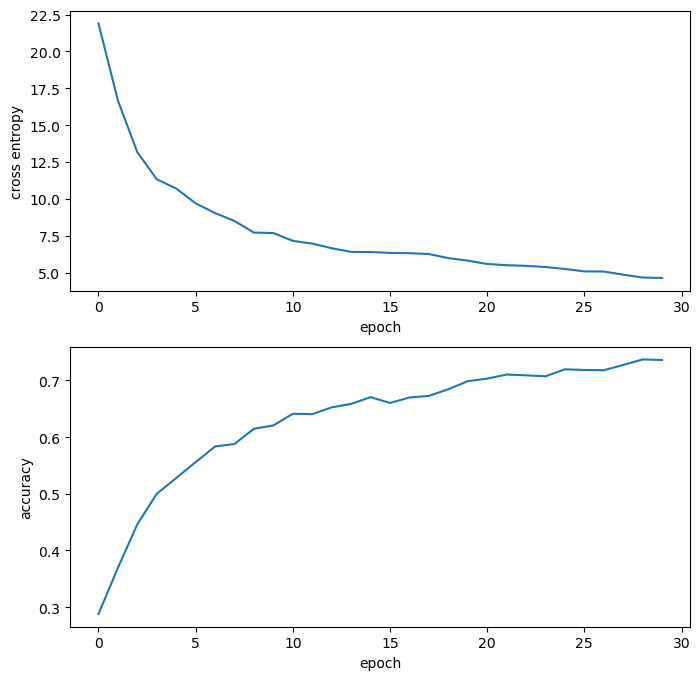

In [5]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(cost)
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.subplot(2,1,2)
plt.plot(accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [6]:
M = np.array([X_train.shape[1],100,200,500,10])
L = M.shape[0] - 1

# initialize for a single input
W = []
for l in range(L):
    W.append(np.random.randn(M[l + 1],M[l]))
    print(W[l].shape)

# forward propagation
z = []
a = []
for l in range(L):    
    z.append(np.zeros((M[l + 1])))
    a.append(np.zeros((M[l + 1])))    
y = softmax(z[-1])    

# backpropagation
delta = []
for l in np.arange(L):    
    delta.append(np.zeros((M[l + 1])))
    
pred_train = np.zeros((N_train, M[-1]))

(100, 31)
(200, 100)
(500, 200)
(10, 500)


In [7]:
cost = []
accuracy = []

# stochastic gradient descent
for epoch in range(maxEpoch):  
    N_perm = np.random.permutation(N_train)    
    
    for n in N_perm:        
        W_new = W
        
        x = X_train[n,:]
        t = t_train[n,:] 

        ### forward propagation
        z[0] = W[0].dot(x)
        a[0] = act(z[0])

        # propagation
        for layer in range(L - 1):    
            z[layer + 1] = W[layer + 1].dot(a[layer])
            a[layer + 1] = act(z[layer + 1])

        # output layer
        y = softmax(z[-1])
    
        ### backpropagation
        # output layer
        delta[L - 1] = -(t - y)

        # propagation
        for layer in np.arange(L - 1,1,-1):
            delta[layer - 1] = W[layer].T.dot(delta[layer]) * dact(z[layer - 1])         
        
        # input layer        
        delta[0] = W[1].T.dot(delta[1]) * dact(z[0])

        ### update
        W_new[L - 1] = W_new[L - 1] - eta*delta[L - 1].reshape(-1,1).dot(a[L - 2].reshape(1,-1))
        for layer in np.arange(L - 1,1,-1):
            W_new[layer - 1] = W_new[layer - 1] - eta*delta[layer - 1].reshape(-1,1).dot(a[layer - 2].reshape(1,-1))
        W_new[0] = W_new[0] - eta*delta[0].reshape(-1,1).dot(x.reshape(1,-1))
        
        W = W_new
        
    for n in range(N_train):  
        x = X_train[n,:]
        t = t_train[n,:] 

        ### forward propagation
        z[0] = W[0].dot(x)
        a[0] = act(z[0])

        # propagation
        for layer in range(L - 1):    
            z[layer + 1] = W[layer + 1].dot(a[layer])
            a[layer + 1] = act(z[layer + 1])

        # output layer
        y = softmax(z[-1])

        pred_train[n,:] = y
        
    # performance
    cost.append(cross_entropy(pred_train,t_train))
    accuracy.append(np.sum(y_train == np.argmax(pred_train, axis = 1)) / N_train)
    
    print('[epoch %d] cross entropy: %.4f, accuracy: %.4f'%(epoch,cost[-1],accuracy[-1]))     

[epoch 0] cross entropy: 21.6824, accuracy: 0.1559
[epoch 1] cross entropy: 15.7009, accuracy: 0.2676
[epoch 2] cross entropy: 12.4414, accuracy: 0.3346
[epoch 3] cross entropy: 12.2814, accuracy: 0.3327
[epoch 4] cross entropy: 11.4440, accuracy: 0.3632
[epoch 5] cross entropy: 10.0640, accuracy: 0.3775
[epoch 6] cross entropy: 8.8643, accuracy: 0.4204
[epoch 7] cross entropy: 8.3962, accuracy: 0.4270
[epoch 8] cross entropy: 8.2484, accuracy: 0.4355
[epoch 9] cross entropy: 8.0314, accuracy: 0.4431
[epoch 10] cross entropy: 7.3304, accuracy: 0.4979
[epoch 11] cross entropy: 6.5546, accuracy: 0.5261
[epoch 12] cross entropy: 7.1101, accuracy: 0.4893
[epoch 13] cross entropy: 6.6007, accuracy: 0.5065
[epoch 14] cross entropy: 6.2565, accuracy: 0.5098
[epoch 15] cross entropy: 5.7349, accuracy: 0.5277
[epoch 16] cross entropy: 5.4816, accuracy: 0.5383
[epoch 17] cross entropy: 5.0130, accuracy: 0.5531
[epoch 18] cross entropy: 5.1338, accuracy: 0.5378
[epoch 19] cross entropy: 4.4093, a

Text(0, 0.5, 'accuracy')

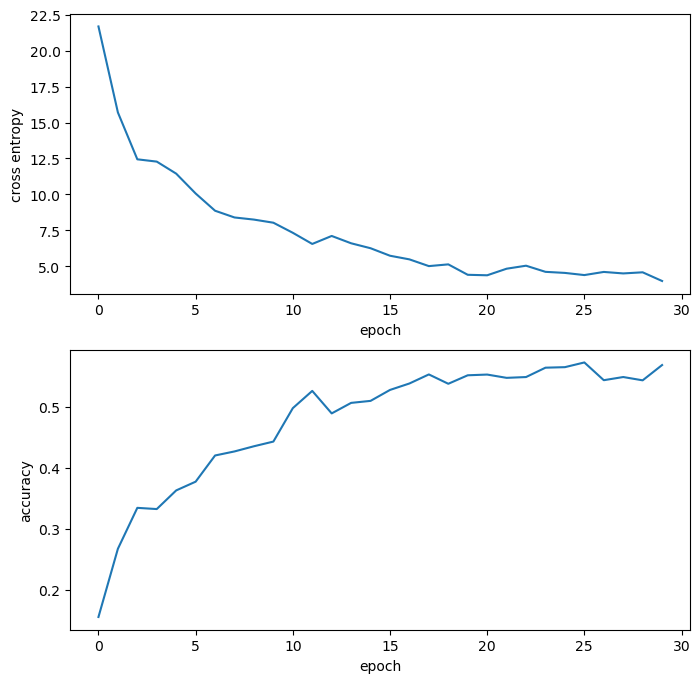

In [8]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(cost)
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.subplot(2,1,2)
plt.plot(accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense

num_classes = 10
epochs = maxEpoch

opt = keras.optimizers.SGD(learning_rate=eta, name="SGD")

model = Sequential()
model.add(Dense(100, activation='tanh', input_dim = X_train.shape[1], use_bias = False, kernel_initializer='random_normal'))
model.add(Dense(1000, activation='tanh', use_bias = False, kernel_initializer='random_normal'))
model.add(Dense(num_classes, activation='softmax', use_bias = False, kernel_initializer='random_normal'))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
hist = model.fit(X_train, t_train, epochs = epochs, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1000)              100000    
                                                                 
 dense_2 (Dense)             (None, 10)                10000     
                                                                 
Total params: 113,100
Trainable params: 113,100
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1875/1875 [==============================] - 2s 1ms/step - loss: 2.4173 - accuracy: 0.1034
Epoch 2/30
1875/1875 [==============================] - 2s 1ms/step - loss: 2.2570 - accuracy: 0.1445
Epoch 3/30
1875/1875 [==============================] - 2s 917us/step - loss: 2.1160 - accuracy: 0.2113
Epoch 